### Set-up

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from data_construct import * ## contains functions for constructing data 
from IRM_methods import *    ## contains IRM games methods 
from models import *         ## contains keras and pytorch models
from optim import *          ## contains keras and pytorch optimizers

### Hyper-parameters

In [3]:
n_epochs         = 2
batch_size       = 256
termination_acc  = 0.6
warm_start       = 100

learning_rate    = 1.0e-3 # 2.5e-4
beta_1           = 0.9  # 0.9
optimizer_name   = "adam"  # "adam" or "sgd"
module_name      = "pytorch"  # "tensorflow" or "pytorch"
variable_phi     = False
extra_grad       = False

### MNIST digits:  2 environments

In [4]:
# Create data for each environment
n_env = 2  # number of environments
p_color_list = [0.2, 0.1] # list of probabilities of switching the final label to obtain the color index
p_label_list = [0.25] * n_env # list of probabilities of switching pre-label

D = assemble_data_mnist() # initialize mnist digits data object
D.create_training_data(n_env, p_color_list, p_label_list) # creates the training environments

p_label_test = 0.25 # probability of switching pre-label in test environment
p_color_test = 0.9  # probability of switching the final label to obtain the color index in test environment

D.create_testing_data(p_color_test, p_label_test, n_env)  # sets up the testing environment
(n_examples,length, width, height) = D.data_tuple_list[0][0].shape # attributes of the data
n_classes = len(np.unique(D.data_tuple_list[0][1])) # number of classes in the data

### Models and the optimizers

In [5]:
models = create_models(module_name=module_name, 
                       variable_phi=variable_phi,
                       n_env=n_env, 
                       length=length, 
                       width=width, 
                       height=height, 
                       n_classes=n_classes)

In [6]:
optimizers = create_optimizers(module_name=module_name, 
                               optimizer_name=optimizer_name,
                               extra_grad=extra_grad,
                               variable_phi=variable_phi,
                               n_env=n_env, 
                               learning_rate=learning_rate,
                               beta_1=beta_1, 
                               params=[models[i_env].parameters() for i_env in range(n_env)]
                                      if module_name == "pytorch" else None)

### IRM game set-up

In [7]:
if module_name == "tensorflow":
    game = TensorflowIrmGame
else:
    game = PytorchIrmGame

F_game = game(models=models, 
              optimizers=optimizers, 
              extra_grad=extra_grad, 
              variable_phi=variable_phi,
              n_epochs=n_epochs,
              batch_size=batch_size, 
              termination_acc=termination_acc, 
              warm_start=warm_start) 

### Training pipeline

Epoch 1/2...


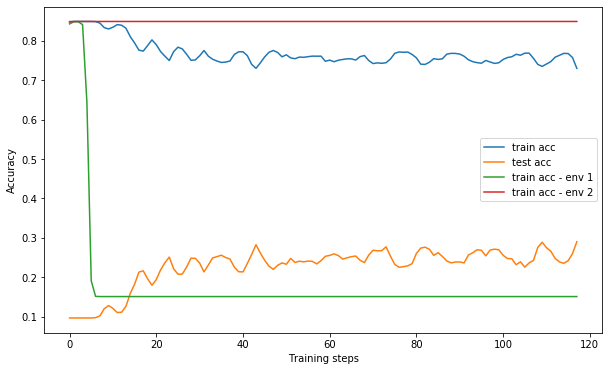

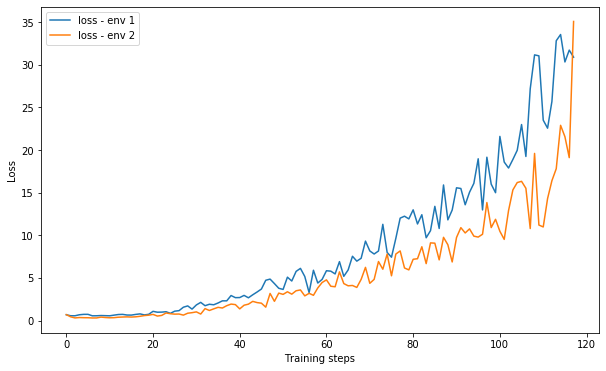

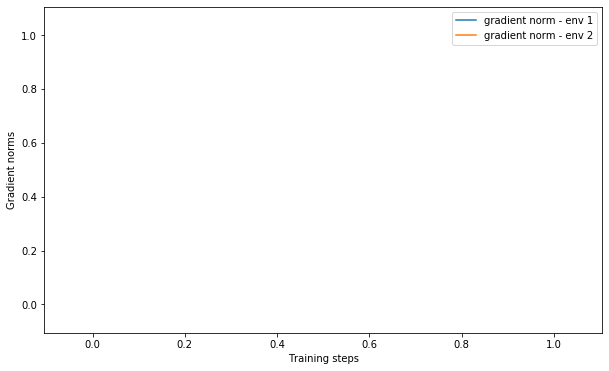

Epoch 2/2...


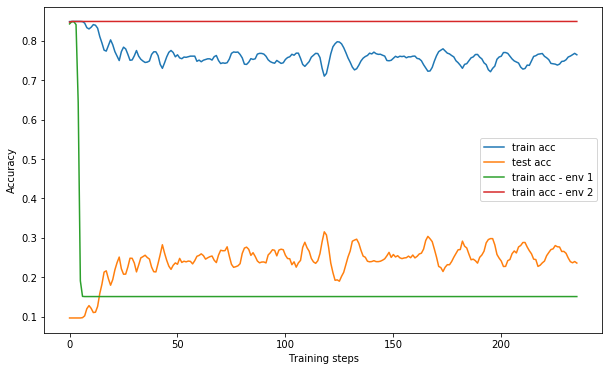

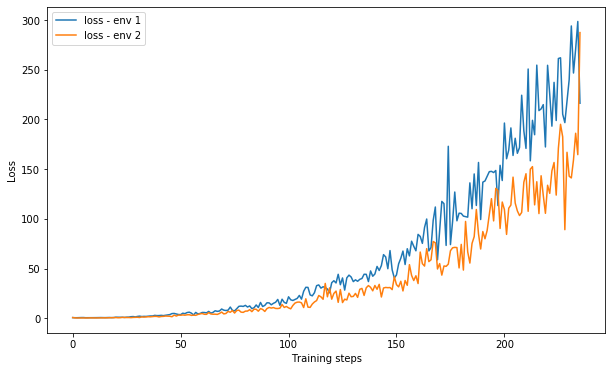

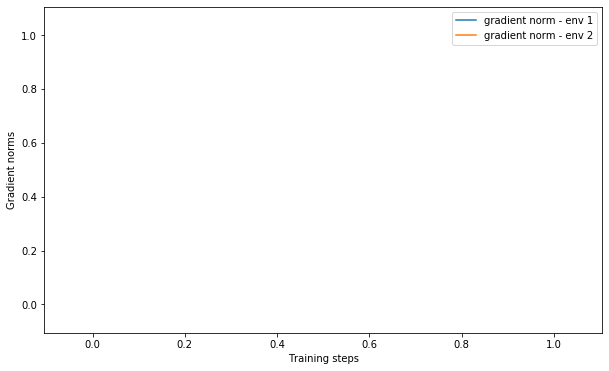

Training accuracy: 0.7645
Testing accuracy: 0.2360


In [8]:
F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

lr = 0.001000
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0



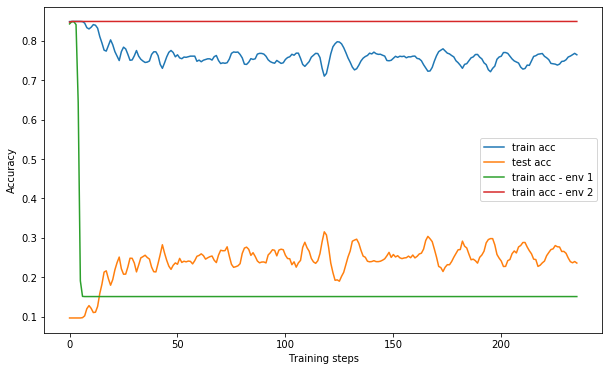

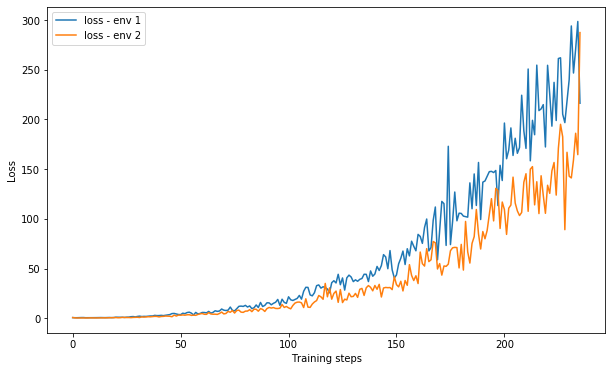

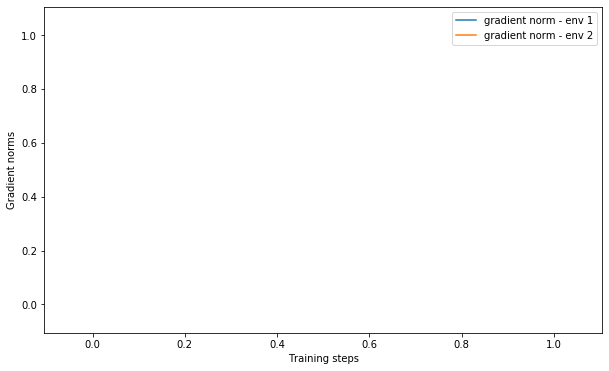

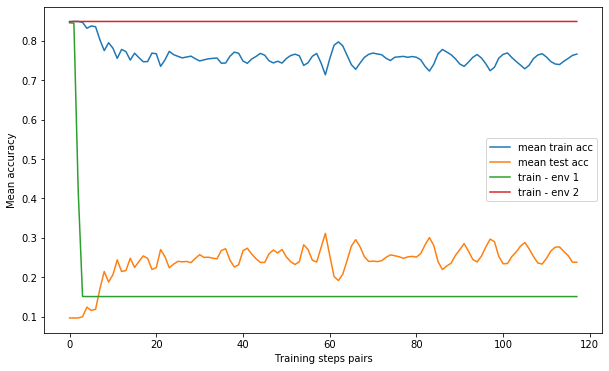

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.001000
beta_1 = 0.900
optimizer = adam
module = tensorflow
extra_grad = 0



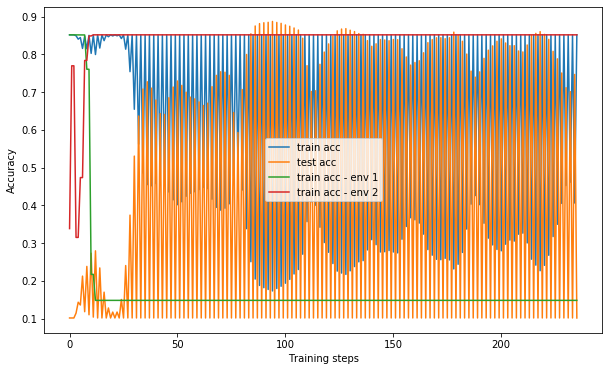

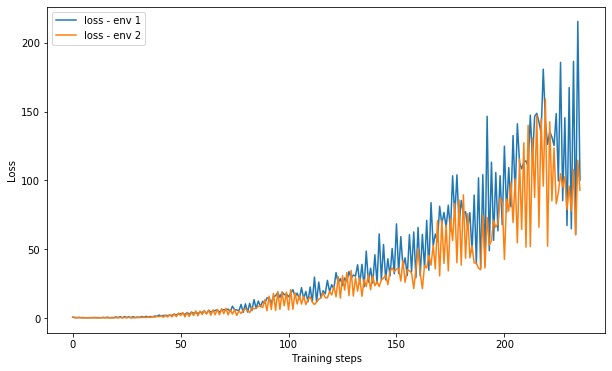

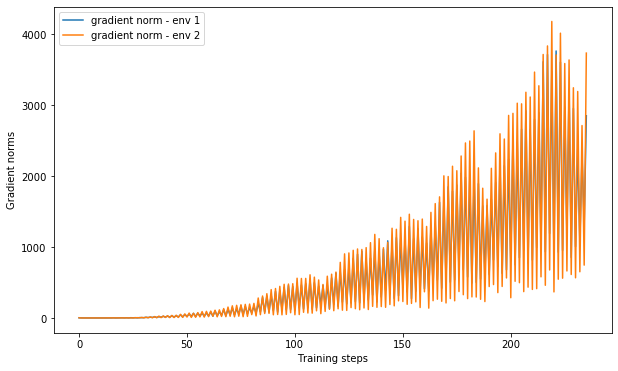

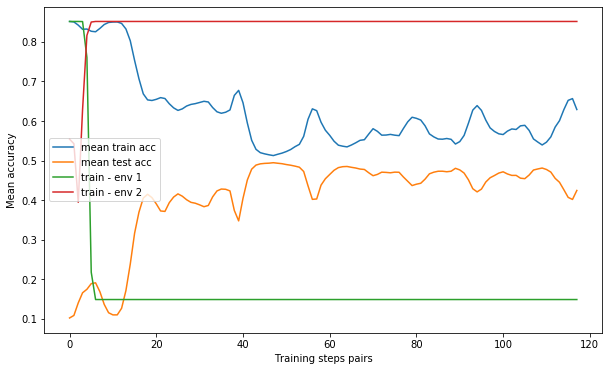

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.001000
beta_1 = 0.900
optimizer = adam
module = tensorflow
extra_grad = 0



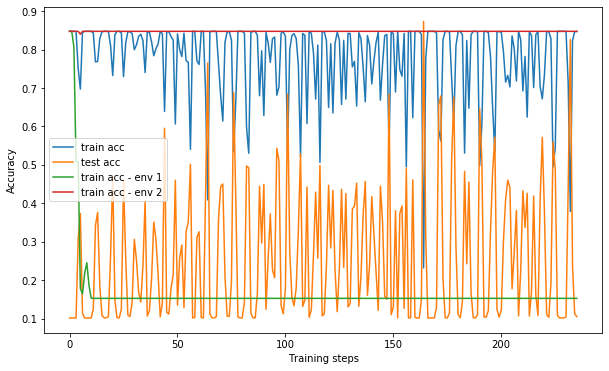

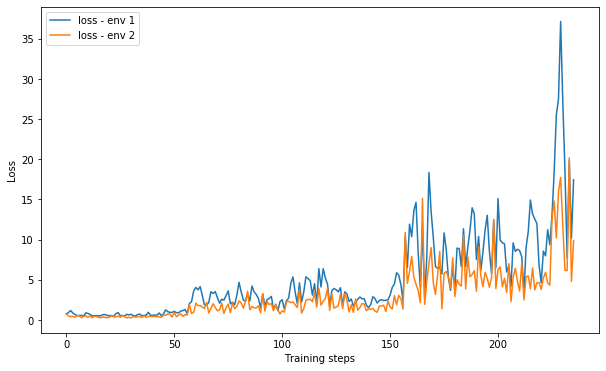

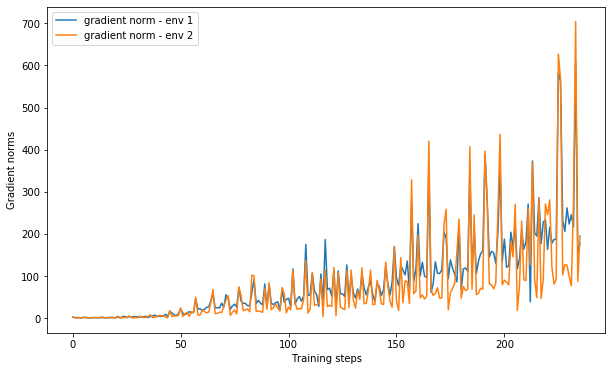

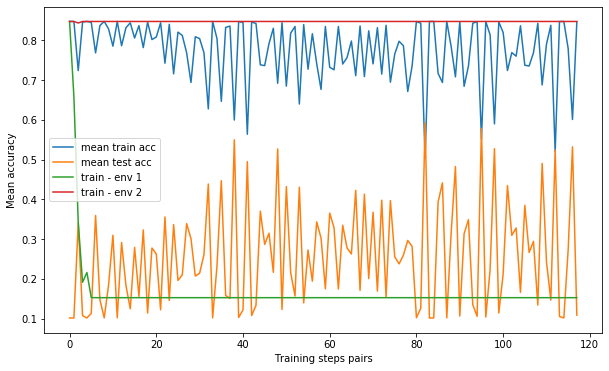

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.001000
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0



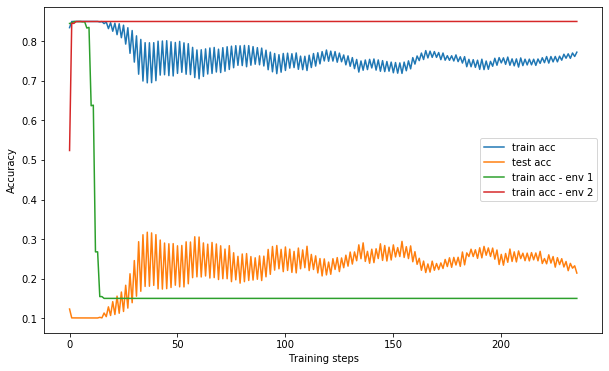

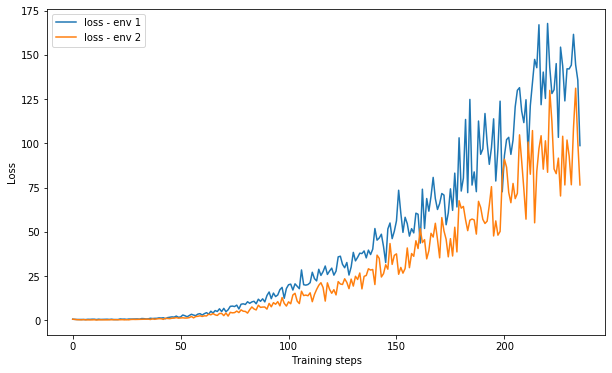

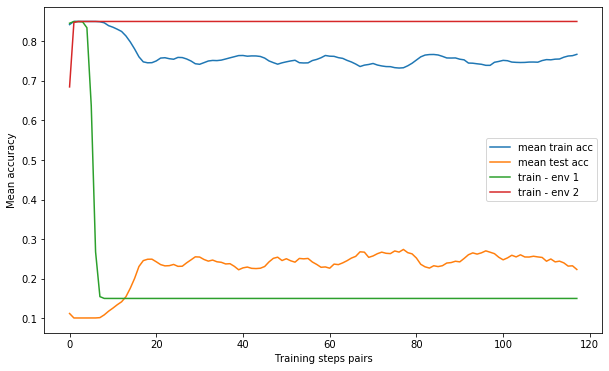

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.001000
beta_1 = 0.900
optimizer = adam
module = tensorflow
extra_grad = 0



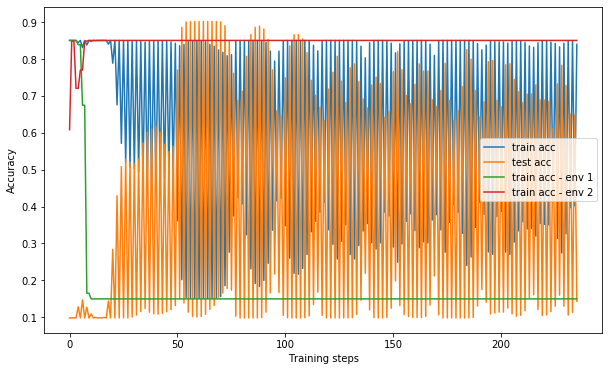

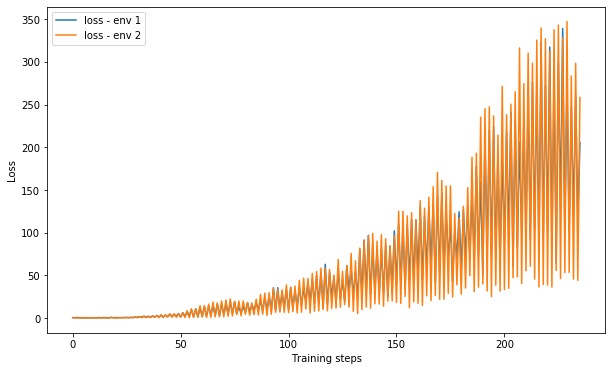

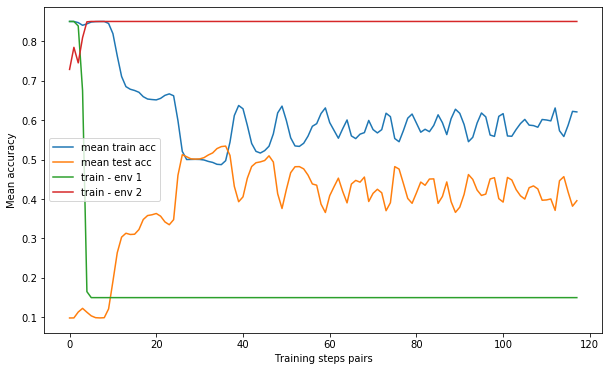

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.001000
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0



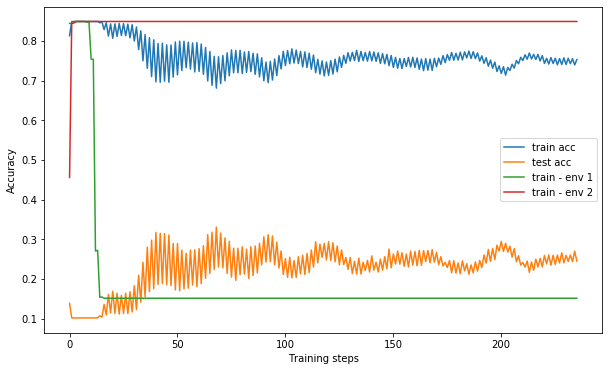

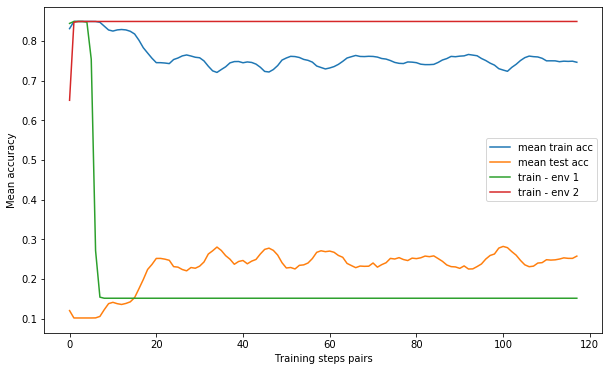

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.000250
beta_1 = 0.900
optimizer = adam
module = tensorflow
extra_grad = 0



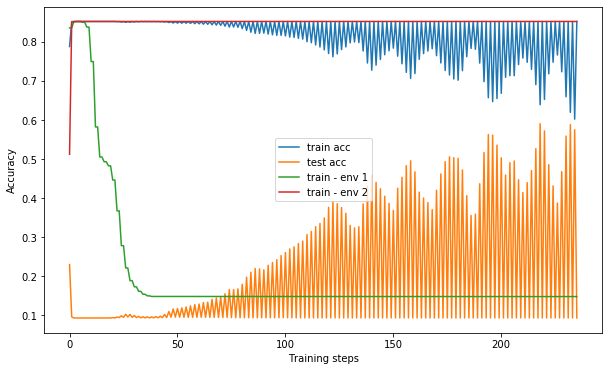

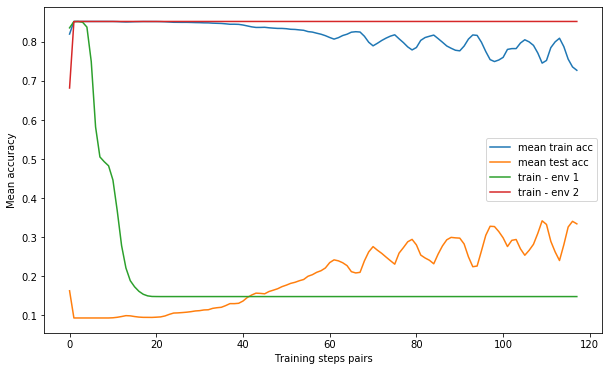

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.000250
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0



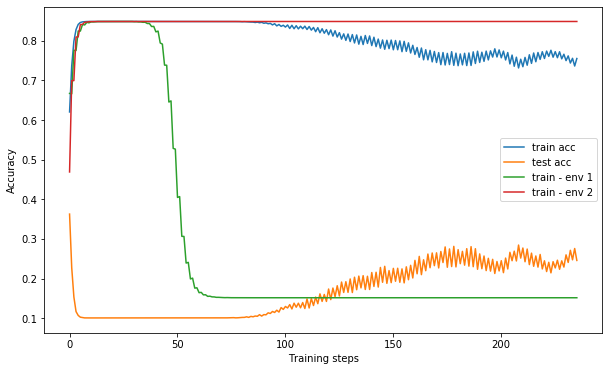

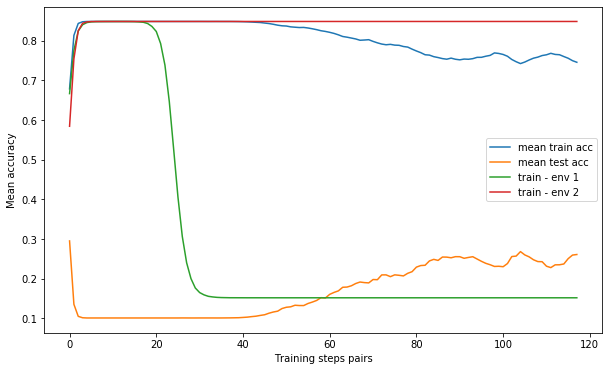

In [18]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)
F_game.mean_plot(env_wise=True)

lr = 0.000250
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0



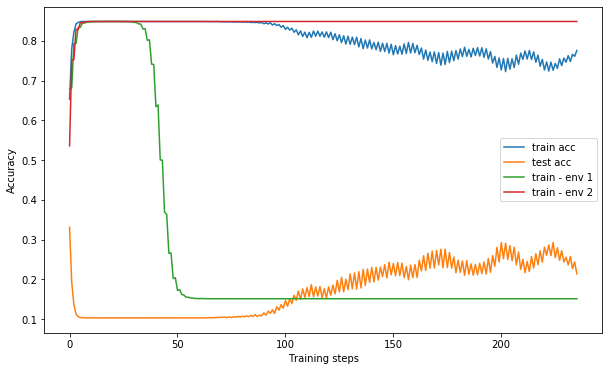

In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))
F_game.plot(env_wise=True)

lr = 0.000250
beta_1 = 0.900
optimizer = adam
module = tensorflow
extra_grad = 0

Epoch 1/2...


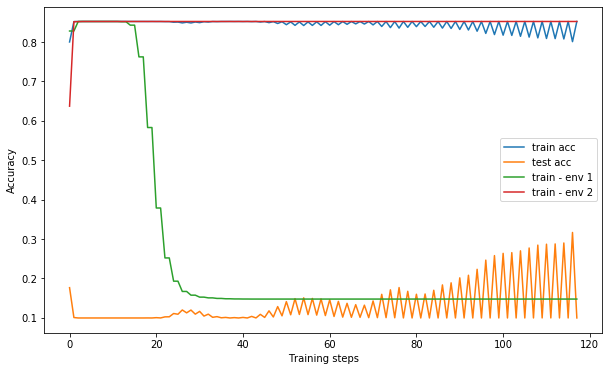

Epoch 2/2...


Early termination.



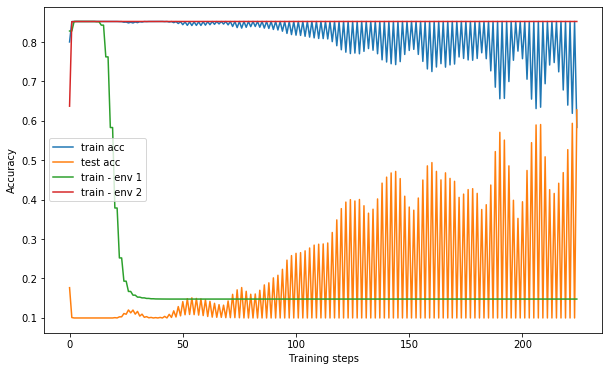

Training accuracy: 0.5835
Testing accuracy: 0.6277


In [8]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

lr = 0.025000
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0

Epoch 1/2...


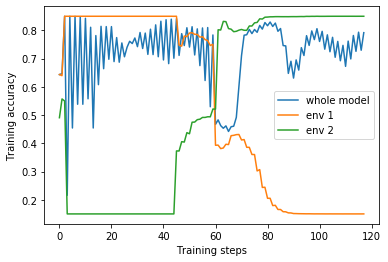

Epoch 2/2...


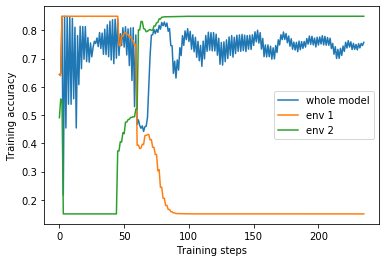

Training accuracy: 0.7576
Testing accuracy: 0.2394


In [9]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

lr = 0.025000
beta_1 = 0.900
optimizer = adam
module = tensorflow
extra_grad = 0

Epoch 1/2...


Early termination.



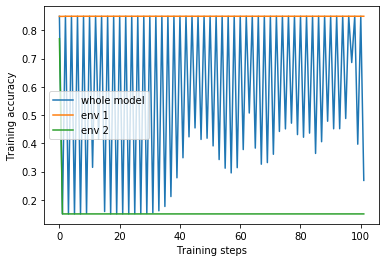

Training accuracy: 0.2686
Testing accuracy: 0.8408


In [8]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

lr = 0.025000
beta_1 = 0.900
optimizer = adam
module = pytorch
extra_grad = 0

Epoch 1/2...


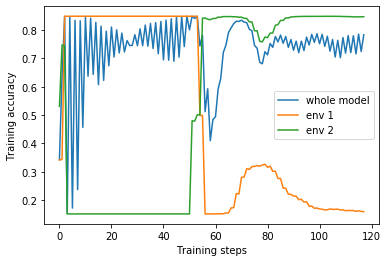

Epoch 2/2...


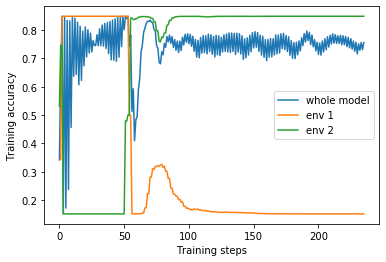

Training accuracy: 0.7559
Testing accuracy: 0.2329


In [8]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

lr=0.002500
beta_1=0.900
optimizer=adam
module=tensorflow
extra_grad=0

Epoch 1/2...


Early termination.



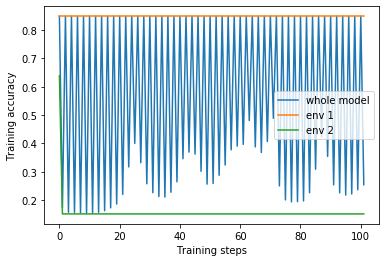

Training accuracy: 0.2544
Testing accuracy: 0.8519


In [8]:
print("lr = %.6f\nbeta_1 = %.3f\noptimizer = %s\nmodule = %s\nextra_grad = %i\n" 
      % (learning_rate, beta_1, optimizer_name, module_name, extra_grad))

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

Epoch 1/2...


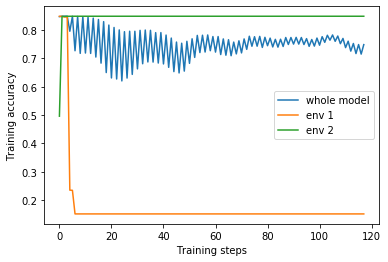

Epoch 2/2...


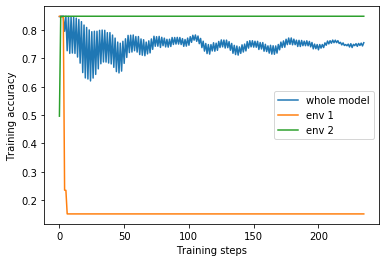

Training accuracy: 0.7555
Testing accuracy: 0.2330


In [8]:
F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

Epoch 1/2...


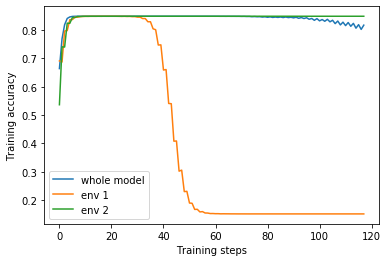

Epoch 2/2...


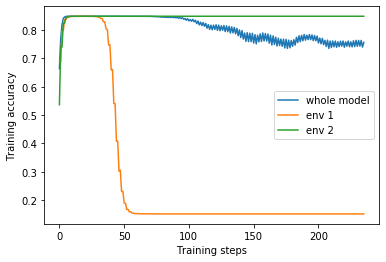

Training accuracy: 0.7560
Testing accuracy: 0.2313


In [8]:
# learning_rate    = 2.5e-4          # 2.5e-4
# beta_1           = 0.9             # 0.9
# optimizer_name   = "adam"          # "adam" or "sgd"
# module_name      = "pytorch"       # "tensorflow" or "pytorch"
# extra_grad       = False

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)

Epoch 1/2...


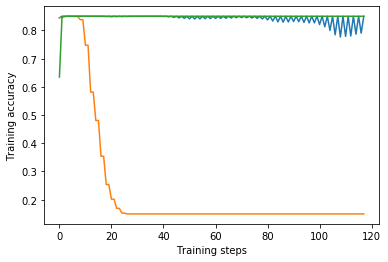

Epoch 2/2...


Early termination.



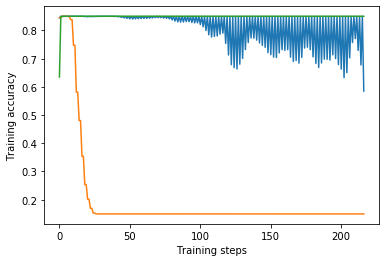

Training accuracy: 0.5853
Testing accuracy: 0.6577


In [9]:
# learning_rate    = 2.5e-4          # 2.5e-4
# beta_1           = 0.9             # 0.9
# optimizer_name   = "adam"          # "adam" or "sgd"
# module_name      = "tensorflow"    # "tensorflow" or "pytorch"
# extra_grad       = False

F_game.fit(data_tuple_train=D.data_tuple_list,
           data_tuple_test=D.data_tuple_test,
           env_wise=True)